In [1]:
import numpy as np
import pandas as pd
import gpflow
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from gpflow.test_util import notebook_niter

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
import itertools
datafile = 'data/jass/rnd_01.csv'
col_names = [a+str(b) for (a,b) in itertools.product([farbe for farbe in 'HKSE'], [bild for bild in range(9)])]+["Geschoben", "Player", "Aktion"]
data = pd.read_csv(datafile, header=None, names=col_names)
data

,H0,H1,H2,H3,H4,H5,H6,H7,H8,K0,...,E2,E3,E4,E5,E6,E7,E8,Geschoben,Player,Aktion
0,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,1631,2
1,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,64310,6
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,16721,1
3,1,0,0,0,1,0,0,0,1,1,...,0,0,1,0,1,0,0,1,0,4
4,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,72620,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161689,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,55942,3
161690,0,0,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,6
161691,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,0,3
161692,0,1,0,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,60659,6


## Multiclass Classification (without _schieben_)

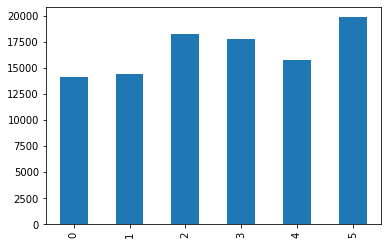

In [3]:
# select subset of data
target_classes = [0,1,2,3,4,5]
num_classes = len(target_classes)
zeroone = data[data['Aktion'].isin(target_classes)]
zeroone = zeroone.drop(columns='Player')
X = zeroone.loc[:,'H0':'Geschoben'].values.astype(float)
y = zeroone.loc[:,'Aktion']
D = X.shape[1]
# print distribution over classes
y.value_counts().sort_index().plot(kind='bar');
y = y.values.astype(float).reshape(-1,1)

## Function to evaluate and save a model

In [6]:
import pathlib
def evaluate(X_train, y_train, kernel, kernel_args, n_classes, inducing_every, name=None, path='./models/07_GPFlow_model_size/', overwrite=False):
    
    if not name is None:
        _path = pathlib.Path(path)
        if not _path.is_dir():
            raise Exception('path to store model does not exist: %s' % path)
        _file = pathlib.Path(path+name)
        if _file.exists():
            if overwrite:
                _file.unlink()
            else:
                print('%s already trained... continue' % (str(path+name)))
                return
    # clear default tensorflow graph/session from previous trainings/predictions
    gpflow.reset_default_graph_and_session()
    
    kern = kernel(**kernel_args)
    
    print('Evaluating kernel: '+kern.name + ' (' + name+ ')')
    print('Datasets: Train: %i (%i inducing variables)' % (len(y_train), len(y_train)//inducing_every))
    
    
    #model
    invlink = gpflow.likelihoods.RobustMax(n_classes) # Robustmax inverse link function
    likelihood = gpflow.likelihoods.MultiClass(n_classes, invlink=invlink)  # Multiclass likelihood

    Z = X_train[::inducing_every].copy()
    m = gpflow.models.SVGP(
        X_train, y_train, kern=kern, likelihood=likelihood,
        Z=Z, num_latent=num_classes, whiten=True, q_diag=True)
    
    # train
    opt = gpflow.train.ScipyOptimizer(options={'maxls': 30,'ftol':1e-10})
    opt.minimize(m, maxiter=notebook_niter(10), step_callback=None, disp=True)
    
    # save model
    if not name is None:
        saver = gpflow.saver.Saver()
        saver.save(path+name, m)

In [12]:
def load_model(name, path='./models/07_GPFlow_model_size/'):
    gpflow.reset_default_graph_and_session()
    return gpflow.saver.Saver().load(path+name)

def accuracy(m, X, y):
    return np.equal(y.reshape(-1), np.argmax(m.predict_y(X)[0], axis=1)).mean()

def create_name(name, train_size, inducing_every):
    return name+'_'+str(train_size)+'_'+str(train_size//inducing_every)

# Compare model size based on number of training/inducing points

In [7]:
for i in [10, 8, 4, 2]:
    # prepare data
    _train_size = 4000
    _test_size = 10000
    _inducing_every = i
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=_train_size, test_size=_test_size, random_state=23)
    _name = create_name('size_comparison', _train_size, _inducing_every)
    r = evaluate(
         X_train=X_train,
         y_train=y_train,
         kernel= gpflow.kernels.RBF,
         kernel_args = {'input_dim': D},
         n_classes=num_classes,
         inducing_every=_inducing_every,
         name=_name, overwrite=False)

Evaluating kernel: SquaredExponential (size_comparison_4000_400)
Datasets: Train: 4000 (400 inducing variables)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 12627.626309
  Number of iterations: 10
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 12627.626309
  Number of iterations: 10
  Number of functions evaluations: 15
/usr/local/lib/python3.6/dist-packages/gpflow/saver/serializers.py:37: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(pathname_or_file_like) as h5file:


Evaluating kernel: SquaredExponential (size_comparison_4000_500)
Datasets: Train: 4000 (500 inducing variables)
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 11172.293858
  Number of iterations: 10
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 11172.293858
  Number of iterations: 10
  Number of functions evaluations: 14
/usr/local/lib/python3.6/dist-packages/gpflow/saver/serializers.py:37: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(pathname_or_file_like) as h5file:


Evaluating kernel: SquaredExponential (size_comparison_4000_1000)
Datasets: Train: 4000 (1000 inducing variables)
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 12321.835407
  Number of iterations: 10
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 12321.835407
  Number of iterations: 10
  Number of functions evaluations: 15
/usr/local/lib/python3.6/dist-packages/gpflow/saver/serializers.py:37: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(pathname_or_file_like) as h5file:


Evaluating kernel: SquaredExponential (size_comparison_4000_2000)
Datasets: Train: 4000 (2000 inducing variables)
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 12232.885529
  Number of iterations: 10
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 12232.885529
  Number of iterations: 10
  Number of functions evaluations: 15
/usr/local/lib/python3.6/dist-packages/gpflow/saver/serializers.py:37: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(pathname_or_file_like) as h5file:


In [11]:
m = load_model('rbf_ard_4000')

/usr/local/lib/python3.6/dist-packages/gpflow/saver/serializers.py:47: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return h5file['data'].value


In [13]:
m2 = load_model('size_comparison_4000_2000')

In [16]:
type(m)

gpflow.models.vgp.VGP

In [17]:
type(m2)

gpflow.models.svgp.SVGP